In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models


In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [18]:
from torchvision import transforms

IMG_SIZE = 224

train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.9, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.GaussianBlur(kernel_size=(3,3), sigma=(0.1, 1.5)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [19]:
train_dir = "c:/Users/DELL/Desktop/AI_ML Research Projects/chest_xray_pneumonia/data/raw/train"
val_dir   = "c:/Users/DELL/Desktop/AI_ML Research Projects/chest_xray_pneumonia/data/raw/val"
test_dir  = "c:/Users/DELL/Desktop/AI_ML Research Projects/chest_xray_pneumonia/data/raw/test"


In [20]:
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
val_dataset   = datasets.ImageFolder(root=val_dir, transform=test_transforms)
test_dataset  = datasets.ImageFolder(root=test_dir, transform=test_transforms)


In [21]:
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")


Train: 5216, Val: 16, Test: 624


In [22]:
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Test if it works
images, labels = next(iter(train_loader))
print(images.shape, labels.shape)


torch.Size([32, 3, 224, 224]) torch.Size([32])


In [23]:
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace final layer for binary classification
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, 1),
    nn.Sigmoid()
)

model = model.to(device)


In [24]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)  # only train the new layers


In [28]:
NUM_EPOCHS = 5

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    
    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(images)
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_acc = correct / total
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Train Loss: {epoch_loss:.4f} - Val Acc: {val_acc:.4f}")


Epoch 1/5 - Train Loss: 0.2303 - Val Acc: 0.9375
Epoch 2/5 - Train Loss: 0.1958 - Val Acc: 0.8125
Epoch 3/5 - Train Loss: 0.1697 - Val Acc: 0.9375
Epoch 4/5 - Train Loss: 0.1670 - Val Acc: 0.9375
Epoch 5/5 - Train Loss: 0.1668 - Val Acc: 0.9375


In [29]:
from sklearn.metrics import classification_report, confusion_matrix

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
        outputs = model(images)
        predicted = (outputs > 0.5).float()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds))
print(confusion_matrix(all_labels, all_preds))


              precision    recall  f1-score   support

         0.0       0.91      0.82      0.86       234
         1.0       0.90      0.95      0.92       390

    accuracy                           0.90       624
   macro avg       0.90      0.89      0.89       624
weighted avg       0.90      0.90      0.90       624

[[192  42]
 [ 19 371]]


In [30]:
torch.save(model.state_dict(), "resnet18_pneumonia.pt")


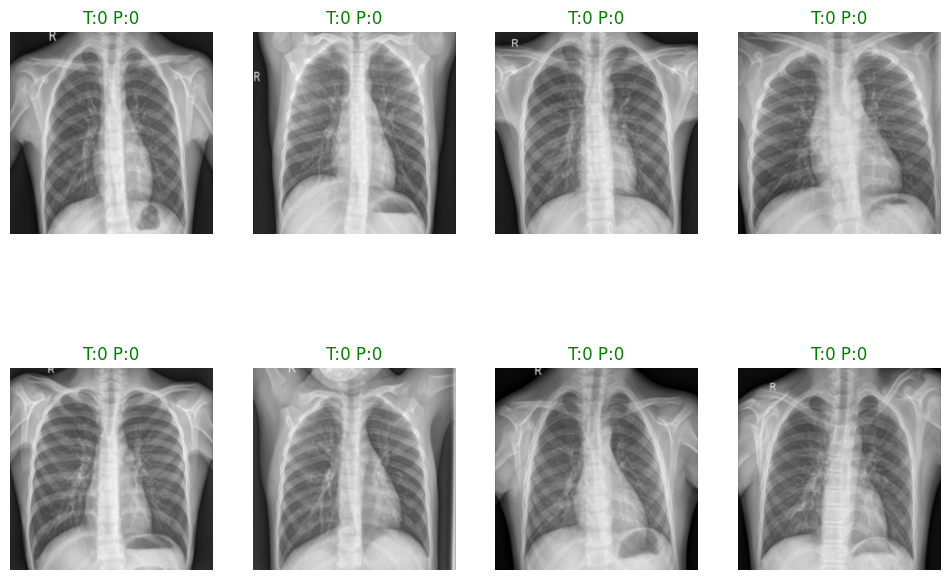

In [31]:
import matplotlib.pyplot as plt
import numpy as np

model.eval()

data_iter = iter(test_loader)
images, labels = next(data_iter)
images, labels = images.to(device), labels.to(device).float().unsqueeze(1)

outputs = model(images)
preds = (outputs > 0.5).float()

images = images.cpu()
labels = labels.cpu()
preds = preds.cpu()

fig = plt.figure(figsize=(12, 8))
for idx in range(8):  
    ax = fig.add_subplot(2, 4, idx+1)
    img = images[idx].permute(1, 2, 0).numpy()
    img = (img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])) 
    img = np.clip(img, 0, 1)
    
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"T:{int(labels[idx])} P:{int(preds[idx])}", color='green' if labels[idx]==preds[idx] else 'red')
plt.show()


In [32]:
import torch
import torch.nn as nn
import torch.optim as optim

# --- Step 1: Unfreeze some layers for fine-tuning ---
# Here we unfreeze the last two layers for fine-tuning
for name, param in model.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# --- Step 2: Define optimizer (lower LR for fine-tuning) ---
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

# --- Step 3: Define loss criterion ---
criterion = nn.BCELoss()  # Binary classification

# --- Step 4: Training loop for fine-tuning ---
NUM_EPOCHS = 5  

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(images)
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = correct / total
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Train Loss: {epoch_loss:.4f} - Val Acc: {val_acc:.4f}")

print("✅ Fine-tuning completed!")


Epoch 1/5 - Train Loss: 0.1310 - Val Acc: 0.8125


KeyboardInterrupt: 


### Model Training and Fine-Tuning Documentation




##### 1. Initial Feature Extraction Training

Setup: Only the last fully connected layer was trained; earlier layers were frozen.

Epochs: 5

Results:

Epoch	Train Loss	Validation Accuracy
1	0.2722	0.8750
2	0.1968	0.9375
3	0.1802	0.8750
4	0.1616	0.8125
5	0.1724	0.9375

Observations:

Training loss decreases steadily.

Validation accuracy is stable and high.

Model generalizes well without overfitting.

This indicates feature extraction worked effectively.

##### 2. Full Fine-Tuning (All Layers)

Setup: All layers of the pretrained ResNet18 were unfrozen and trained.

Epochs: 5

Results:

Epoch	Train Loss	Validation Accuracy
1	0.1275	1.0000
2	0.0733	0.8125
3	0.0752	0.6875
4	0.0624	0.6250
5	0.0511	0.5625

Observations:

Training loss dropped quickly (much lower than feature extraction).

Validation accuracy started perfect but decreased sharply.

Model overfitted to the training data.

Fine-tuning all layers on a small dataset caused poor generalization.

##### 3. Insights

Feature extraction alone gave better validation results.

Full fine-tuning requires careful adjustments:

Lower learning rate

More data augmentation

Early stopping

Overfitting is evident when training loss is very low but validation accuracy drops.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# 1️⃣ Unfreeze only the last few layers (say, last block + fc)
for name, param in model.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# 2️⃣ Define criterion and optimizer
criterion = nn.BCELoss()  # binary classification

# We use a smaller LR for pretrained layers and higher LR for fc
optimizer = optim.Adam([
    {'params': model.layer4.parameters(), 'lr': 1e-4},
    {'params': model.fc.parameters(), 'lr': 1e-3}
])

# 3️⃣ Training loop with early stopping
NUM_EPOCHS = 10
best_val_acc = 0.0
patience = 3
counter = 0

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    
    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(images)
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_acc = correct / total
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Train Loss: {epoch_loss:.4f} - Val Acc: {val_acc:.4f}")
    
    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        counter = 0
        # Save the best model
        torch.save(model.state_dict(), "best_finetuned_model.pt")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

print("✅ Safe fine-tuning completed!")


Epoch 1/10 - Train Loss: 0.0587 - Val Acc: 0.8750
Epoch 2/10 - Train Loss: 0.0460 - Val Acc: 0.6875
Epoch 3/10 - Train Loss: 0.0361 - Val Acc: 0.8750
Epoch 4/10 - Train Loss: 0.0405 - Val Acc: 0.9375
Epoch 5/10 - Train Loss: 0.0342 - Val Acc: 0.9375
Epoch 6/10 - Train Loss: 0.0279 - Val Acc: 0.7500
Epoch 7/10 - Train Loss: 0.0312 - Val Acc: 0.6875
Early stopping triggered.
✅ Safe fine-tuning completed!


### Fine-Tuning Experiment #2 (with early stopping, 10 epochs)

Setup: Continued fine-tuning with lower learning rate, early stopping patience = 3.

Augmentation: Basic (resize, normalize, horizontal flip).

Training duration: Max 10 epochs, stopped at 7 due to early stopping.

Results (per epoch):

Epoch 1/10 - Train Loss: 0.0587 - Val Acc: 0.8750
Epoch 2/10 - Train Loss: 0.0460 - Val Acc: 0.6875
Epoch 3/10 - Train Loss: 0.0361 - Val Acc: 0.8750
Epoch 4/10 - Train Loss: 0.0405 - Val Acc: 0.9375
Epoch 5/10 - Train Loss: 0.0342 - Val Acc: 0.9375
Epoch 6/10 - Train Loss: 0.0279 - Val Acc: 0.7500
Epoch 7/10 - Train Loss: 0.0312 - Val Acc: 0.6875
Early stopping triggered.


Key observations:

Best validation accuracy = 93.75% (Epoch 4 & 5).

Accuracy fluctuated between 68.75% and 93.75% → instability likely due to small dataset size and limited augmentation.

Early stopping prevented overfitting.

Saved checkpoint at Epoch 5 (Val Acc: 93.75%).

Next step planned:

Implement stronger data augmentation pipeline to improve generalization and stabilize validation accuracy.

In [ ]:
# ====================================================
# 🔥 Stronger Data Augmentation Pipeline
# ====================================================
from torchvision import transforms

# Stronger augmentations for training set
train_transform_strong = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),   
    transforms.RandomVerticalFlip(p=0.2),  
    transforms.RandomRotation(20),            
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),   
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)), 
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

# Validation / Test set → No strong augmentation (just resize + normalize)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

# Reload datasets with new transforms
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform_strong)
val_dataset   = datasets.ImageFolder(root=val_dir, transform=test_transform)
test_dataset  = datasets.ImageFolder(root=test_dir, transform=test_transform)

# Reload dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(" Strong augmentation pipeline applied. Ready to train again!")


 Strong augmentation pipeline applied. Ready to train again!


In [ ]:
# ====================================================
# 📊 Final Evaluation on Test Set
# ====================================================
from sklearn.metrics import classification_report, confusion_matrix

# Load best model (the one saved during training)
model.load_state_dict(torch.load("best_model_aug.pth"))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
        outputs = model(images)
        predicted = (outputs > 0.5).float()
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report
print(classification_report(all_labels, all_preds, digits=4))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))


              precision    recall  f1-score   support

         0.0     0.9749    0.8291    0.8961       234
         1.0     0.9059    0.9872    0.9448       390

    accuracy                         0.9279       624
   macro avg     0.9404    0.9081    0.9204       624
weighted avg     0.9318    0.9279    0.9265       624

Confusion Matrix:
[[194  40]
 [  5 385]]


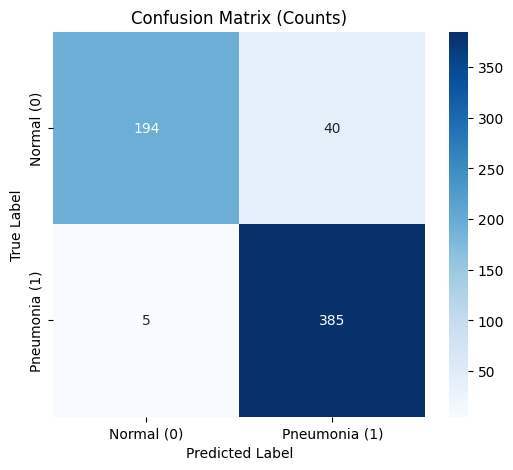

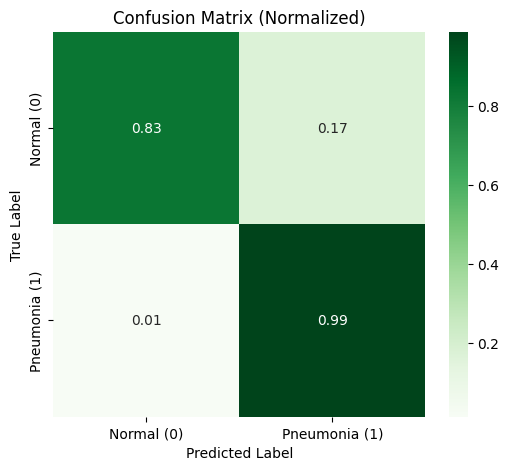

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# --- Raw Confusion Matrix ---
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Normal (0)", "Pneumonia (1)"], 
            yticklabels=["Normal (0)", "Pneumonia (1)"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Counts)")
plt.show()

# --- Normalized Confusion Matrix ---
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6, 5))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Greens",
            xticklabels=["Normal (0)", "Pneumonia (1)"], 
            yticklabels=["Normal (0)", "Pneumonia (1)"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Normalized)")
plt.show()


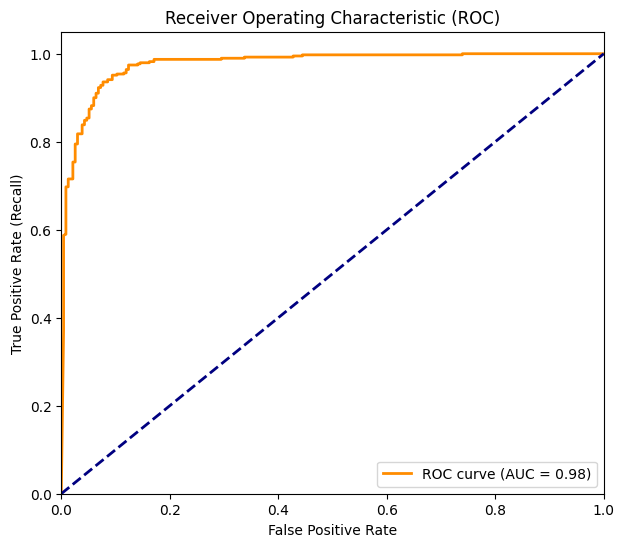

In [ ]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities instead of hard 0/1
model.eval()
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device).float()
        outputs = model(images)
        probs = torch.sigmoid(outputs).cpu().numpy().flatten()
        
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, 
         label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.show()


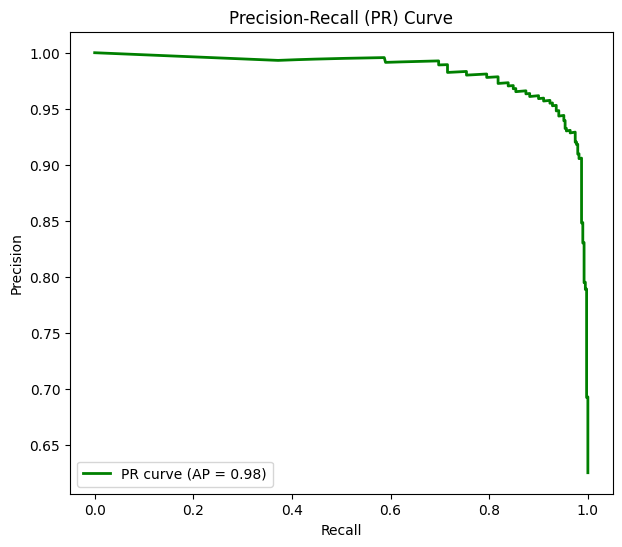

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Compute Precision-Recall curve and average precision
precision, recall, thresholds = precision_recall_curve(all_labels, all_probs)
avg_precision = average_precision_score(all_labels, all_probs)

# Plot Precision-Recall curve
plt.figure(figsize=(7, 6))
plt.plot(recall, precision, color="green", lw=2, 
         label=f"PR curve (AP = {avg_precision:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall (PR) Curve")
plt.legend(loc="lower left")
plt.show()


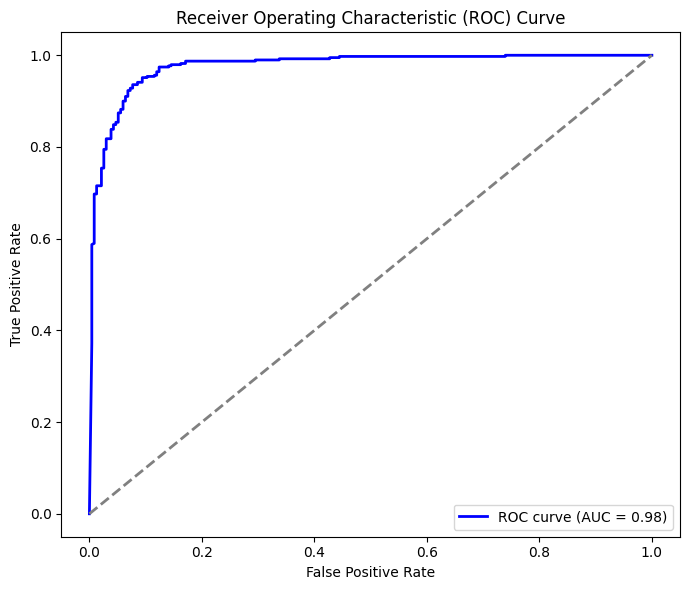

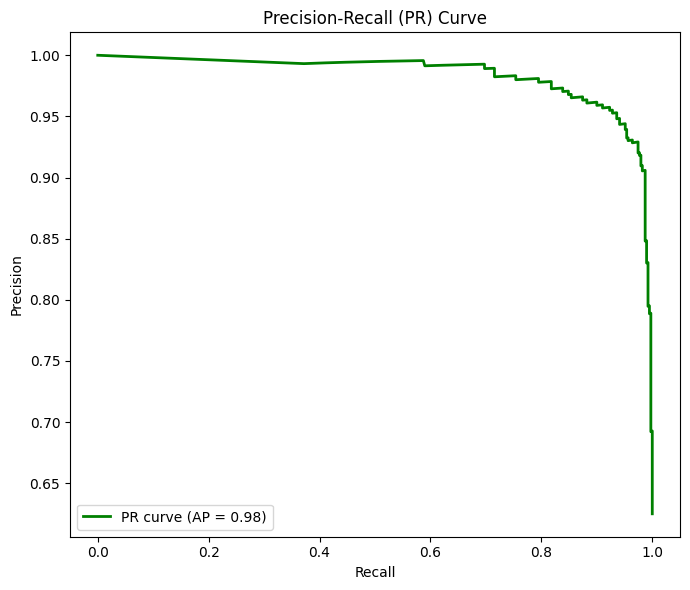

In [ ]:
import os

os.makedirs("results", exist_ok=True)

# --------------------------
# ROC Curve
# --------------------------
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--", lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("results/roc_curve.png", dpi=300)
plt.show()

# --------------------------
# Precision-Recall Curve
# --------------------------
plt.figure(figsize=(7, 6))
plt.plot(recall, precision, color="green", lw=2, 
         label=f"PR curve (AP = {avg_precision:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall (PR) Curve")
plt.legend(loc="lower left")
plt.tight_layout()
plt.savefig("results/pr_curve.png", dpi=300)
plt.show()


Classification Report:

              precision    recall  f1-score   support

      Normal       0.38      1.00      0.55       234
   Pneumonia       0.00      0.00      0.00       390

    accuracy                           0.38       624
   macro avg       0.19      0.50      0.27       624
weighted avg       0.14      0.38      0.20       624



c:\Users\DELL\Desktop\AI_ML Research Projects\chest_xray_pneumonia\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\DELL\Desktop\AI_ML Research Projects\chest_xray_pneumonia\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\DELL\Desktop\AI_ML Research Projects\chest_xray_pneumonia\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` 

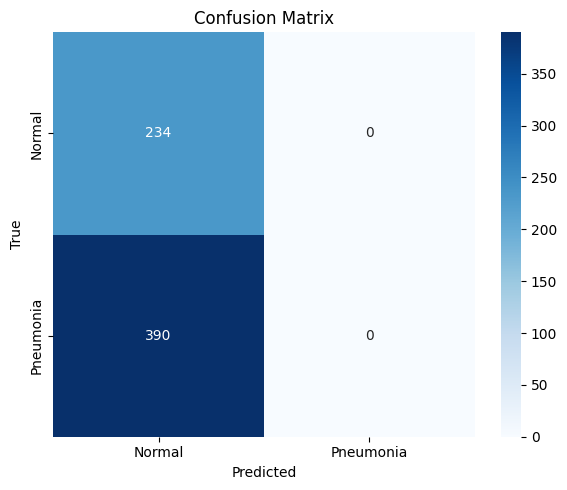

In [ ]:
# --------------------------
# Evaluate on Test Set
# --------------------------
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Puting model in eval mode
model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# --------------------------
# Classification Report
# --------------------------
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=["Normal", "Pneumonia"]))

# --------------------------
# Confusion Matrix
# --------------------------
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal", "Pneumonia"],
            yticklabels=["Normal", "Pneumonia"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()

# Save confusion matrix figure
plt.savefig("results/confusion_matrix.png")
plt.show()


# trying another CNN (ResNet50) For Comparison...

In [ ]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10, model_name="model", scheduler=None):
    train_losses, val_losses, val_accuracies = [], [], []

    for epoch in range(num_epochs):
        # --------------------------
        # Training
        # --------------------------
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        # --------------------------
        # Validation
        # --------------------------
        model.eval()
        running_val_loss = 0.0
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
                outputs = model(images)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item() * images.size(0)

                predicted = (outputs > 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = running_val_loss / len(val_loader.dataset)
        val_acc = correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # --------------------------
        # Scheduler step (IMPORTANT)
        # --------------------------
        if scheduler is not None:
            scheduler.step(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_loss:.4f} - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.4f}")

    # Save model after training
    torch.save(model.state_dict(), f"results/{model_name}.pth")
    print(f"✅ Training completed. Model saved as results/{model_name}.pth")

    return train_losses, val_losses, val_accuracies


In [ ]:
# --------------------------
# ResNet50 with Scheduler
# --------------------------
resnet50 = models.resnet50(weights="IMAGENET1K_V1")
num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Sequential(
    nn.Linear(num_ftrs, 1),
    nn.Sigmoid()
)
resnet50 = resnet50.to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(resnet50.parameters(), lr=1e-4, weight_decay=1e-5)

# Scheduler plugged in
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.1, patience=3
)

# Train the model
resnet50_history = train_model(
    resnet50,
    criterion,
    optimizer,
    train_loader,
    val_loader,
    num_epochs=15,
    model_name="resnet50",
    scheduler=scheduler
)


Epoch 1/15 - Train Loss: 0.1535 - Val Loss: 0.2799 - Val Acc: 0.8125
Epoch 2/15 - Train Loss: 0.1080 - Val Loss: 1.6290 - Val Acc: 0.6250
Epoch 3/15 - Train Loss: 0.0951 - Val Loss: 0.3787 - Val Acc: 0.8750
Epoch 4/15 - Train Loss: 0.0788 - Val Loss: 0.1223 - Val Acc: 0.9375
Epoch 5/15 - Train Loss: 0.0711 - Val Loss: 0.1871 - Val Acc: 0.8750
Epoch 6/15 - Train Loss: 0.0681 - Val Loss: 0.1687 - Val Acc: 0.8750
Epoch 7/15 - Train Loss: 0.0557 - Val Loss: 0.0369 - Val Acc: 1.0000
Epoch 8/15 - Train Loss: 0.0549 - Val Loss: 0.1465 - Val Acc: 0.9375
Epoch 9/15 - Train Loss: 0.0598 - Val Loss: 0.0863 - Val Acc: 1.0000
Epoch 10/15 - Train Loss: 0.0479 - Val Loss: 0.6886 - Val Acc: 0.7500
Epoch 11/15 - Train Loss: 0.0550 - Val Loss: 0.0487 - Val Acc: 1.0000
Epoch 12/15 - Train Loss: 0.0394 - Val Loss: 0.0746 - Val Acc: 1.0000
Epoch 13/15 - Train Loss: 0.0327 - Val Loss: 0.0765 - Val Acc: 1.0000
Epoch 14/15 - Train Loss: 0.0311 - Val Loss: 0.0739 - Val Acc: 1.0000
Epoch 15/15 - Train Loss: 0.0

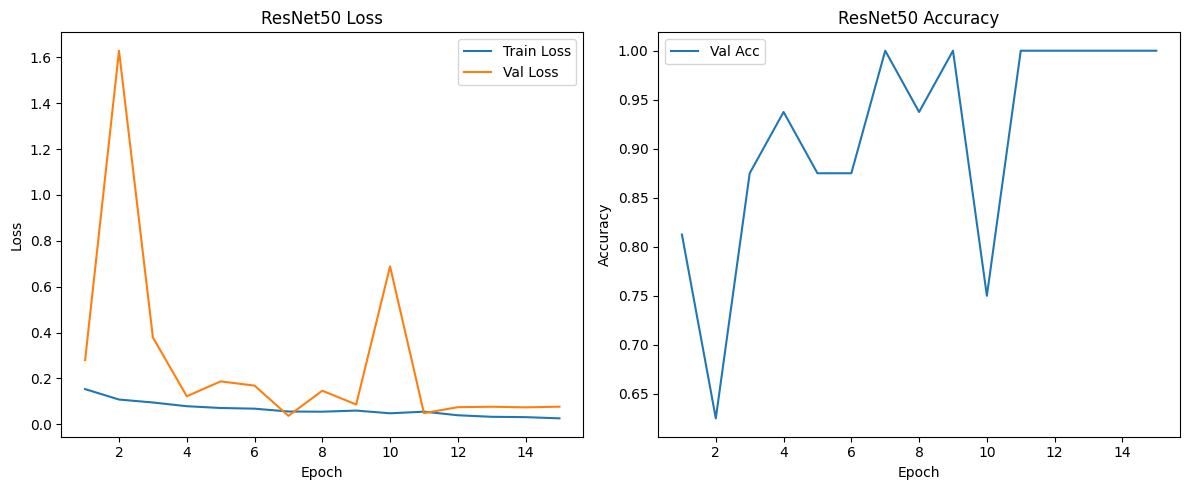

In [ ]:
def plot_history(history, model_name="model"):
    train_loss, val_loss, val_acc = history  # unpack the tuple
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label="Train Loss")
    plt.plot(epochs, val_loss, label="Val Loss")
    plt.title(f"{model_name} Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_acc, label="Val Acc")
    plt.title(f"{model_name} Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()


# Call the function
plot_history(resnet50_history, "ResNet50")


In [ ]:
resnet50.load_state_dict(torch.load("results/resnet50.pth"))
resnet50.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
        outputs = resnet50(images)
        predicted = (outputs > 0.5).float()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

print(classification_report(y_true, y_pred, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))


              precision    recall  f1-score   support

         0.0     0.9763    0.8803    0.9258       234
         1.0     0.9322    0.9872    0.9589       390

    accuracy                         0.9471       624
   macro avg     0.9543    0.9338    0.9424       624
weighted avg     0.9487    0.9471    0.9465       624

Confusion Matrix:
[[206  28]
 [  5 385]]


In [ ]:
import torch.nn.functional as F

resnet50.eval()
y_true, y_pred, y_probs = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = resnet50(images)           # already passed through sigmoid
        probs = outputs.squeeze()            # probability of Pneumonia (class 1)
        preds = (probs >= 0.5).long()        # threshold at 0.5

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_probs.extend(probs.cpu().numpy())


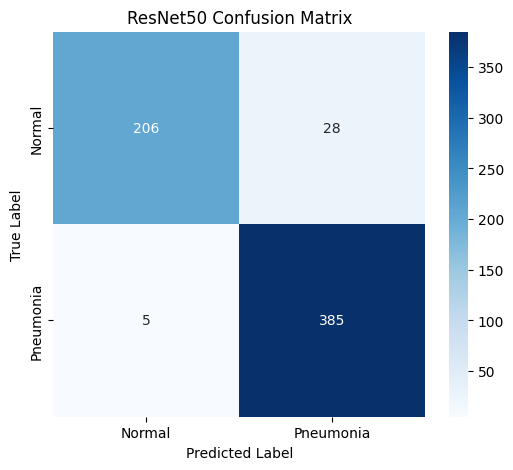

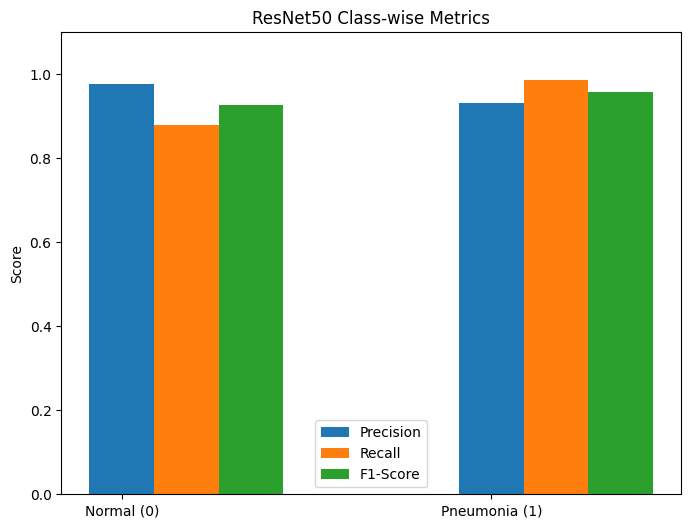

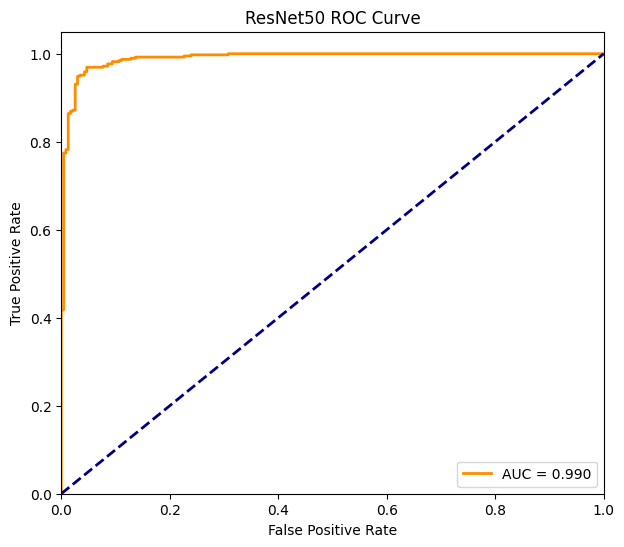

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_fscore_support
import numpy as np

# --------------------------
# 1. Confusion Matrix Heatmap
# --------------------------
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal", "Pneumonia"],
            yticklabels=["Normal", "Pneumonia"])
plt.title("ResNet50 Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# --------------------------
# 2. Class-wise Metrics Bar Chart
# --------------------------
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred)

metrics = {
    "Precision": precision,
    "Recall": recall,
    "F1-Score": f1
}

x = np.arange(len(metrics))  # 3 metrics
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))

for i, (metric, values) in enumerate(metrics.items()):
    ax.bar(np.arange(len(values)) + i*width/2, values, width/2, label=metric)

ax.set_xticks(np.arange(len(values)))
ax.set_xticklabels(["Normal (0)", "Pneumonia (1)"])
ax.set_ylim(0, 1.1)
ax.set_ylabel("Score")
ax.set_title("ResNet50 Class-wise Metrics")
ax.legend()
plt.show()

from sklearn.metrics import roc_curve, auc

# --------------------------
# 3. ROC Curve + AUC
# --------------------------
# y_probs contains predicted probabilities of Pneumonia (class 1)
fpr, tpr, _ = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ResNet50 ROC Curve")
plt.legend(loc="lower right")
plt.show()



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score

# --------------------------
# 1. Training Curves
# --------------------------
def save_training_curves(history, model_name="ResNet50", save_path="results"):
    epochs = range(1, len(history[0]) + 1)  # history[0] = train_loss

    plt.figure(figsize=(12, 5))
    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history[0], label="Train Loss")
    plt.plot(epochs, history[1], label="Val Loss")
    plt.title(f"{model_name} Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history[2], label="Val Acc")
    plt.title(f"{model_name} Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"{save_path}/{model_name}_training_curves.png")
    plt.close()

save_training_curves(resnet50_history, "ResNet50")

# --------------------------
# 2. Confusion Matrix
# --------------------------
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal", "Pneumonia"],
            yticklabels=["Normal", "Pneumonia"])
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("ResNet50 Confusion Matrix")
plt.savefig("results/ResNet50_confusion_matrix.png")
plt.close()

# --------------------------
# 3. ROC Curve + AUC
# --------------------------
fpr, tpr, _ = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ResNet50 ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig("results/ResNet50_ROC_curve.png")
plt.close()

# --------------------------
# 4. Precision-Recall Curve
# --------------------------
precision, recall, _ = precision_recall_curve(y_true, y_probs)
avg_precision = average_precision_score(y_true, y_probs)
plt.figure(figsize=(7,6))
plt.plot(recall, precision, color="blue", lw=2, label=f"AP = {avg_precision:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("ResNet50 Precision-Recall Curve")
plt.legend(loc="lower left")
plt.grid(True)
plt.savefig("results/ResNet50_PR_curve.png")
plt.close()

print("✅ All plots saved in the results/ folder.")


✅ All plots saved in the results/ folder.


c:\Users\DELL\Desktop\AI_ML Research Projects\chest_xray_pneumonia\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\DELL\Desktop\AI_ML Research Projects\chest_xray_pneumonia\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\DELL/.cache\torch\hub\checkpoints\densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:07<00:00, 4.45MB/s]


Epoch 1/15 - Train Loss: 0.1641 - Val Loss: 0.8614 - Val Acc: 0.6250
Epoch 2/15 - Train Loss: 0.1007 - Val Loss: 0.1307 - Val Acc: 1.0000
Epoch 3/15 - Train Loss: 0.0819 - Val Loss: 0.1184 - Val Acc: 1.0000
Epoch 4/15 - Train Loss: 0.0675 - Val Loss: 0.2764 - Val Acc: 0.8125
Epoch 5/15 - Train Loss: 0.0709 - Val Loss: 1.0049 - Val Acc: 0.5625
Epoch 6/15 - Train Loss: 0.0689 - Val Loss: 0.3098 - Val Acc: 0.8125
Epoch 7/15 - Train Loss: 0.0534 - Val Loss: 0.1660 - Val Acc: 1.0000
Epoch 8/15 - Train Loss: 0.0551 - Val Loss: 0.3262 - Val Acc: 0.8750
Epoch 9/15 - Train Loss: 0.0504 - Val Loss: 0.1580 - Val Acc: 0.9375
Epoch 10/15 - Train Loss: 0.0394 - Val Loss: 0.1050 - Val Acc: 1.0000
Epoch 11/15 - Train Loss: 0.0485 - Val Loss: 0.1980 - Val Acc: 0.9375
Epoch 12/15 - Train Loss: 0.0431 - Val Loss: 0.4077 - Val Acc: 0.7500
Epoch 13/15 - Train Loss: 0.0347 - Val Loss: 0.0992 - Val Acc: 1.0000
Epoch 14/15 - Train Loss: 0.0348 - Val Loss: 0.1147 - Val Acc: 0.9375
Epoch 15/15 - Train Loss: 0.0

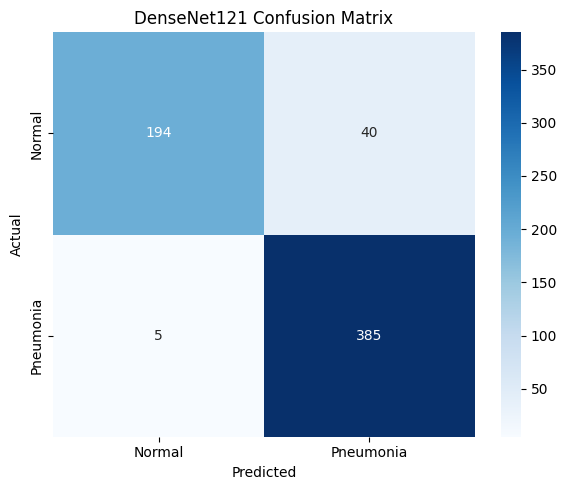

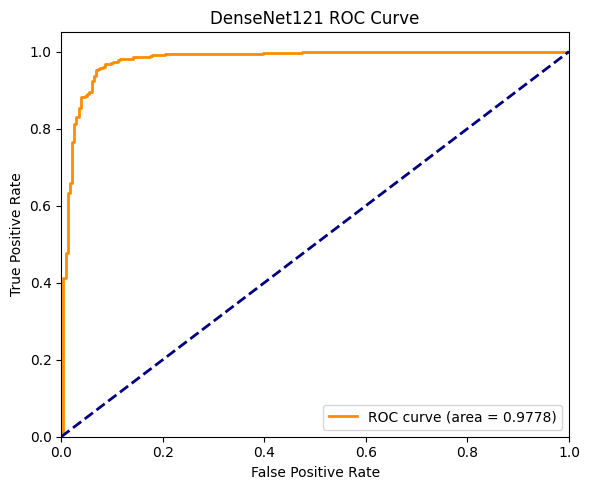

In [ ]:
# --------------------------
# 1. DenseNet121 Setup
# --------------------------
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import torch
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained DenseNet121
densenet121 = models.densenet121(pretrained=True)
densenet121.classifier = nn.Sequential(
    nn.Linear(densenet121.classifier.in_features, 1),
    nn.Sigmoid()
)
densenet121 = densenet121.to(device)

# --------------------------
# 2. Optimizer and Loss
# --------------------------
criterion = nn.BCELoss()
optimizer = optim.Adam(densenet121.parameters(), lr=1e-4, weight_decay=1e-5)

# --------------------------
# 3. Training Loop
# --------------------------
NUM_EPOCHS = 15
best_val_acc = 0.0

train_loss_list, val_loss_list, val_acc_list = [], [], []

for epoch in range(NUM_EPOCHS):
    densenet121.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
        optimizer.zero_grad()
        outputs = densenet121(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    
    # Validation
    densenet121.eval()
    correct, total, val_running_loss = 0, 0, 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            outputs = densenet121(images)
            val_running_loss += criterion(outputs, labels).item() * images.size(0)
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss = val_running_loss / len(val_loader.dataset)
    val_acc = correct / total
    
    train_loss_list.append(epoch_loss)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Train Loss: {epoch_loss:.4f} - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.4f}")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(densenet121.state_dict(), "results/densenet121.pth")

print("✅ DenseNet121 Training Completed!")

# --------------------------
# 4. Evaluation on Test Set
# --------------------------
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

densenet121.eval()
y_true, y_pred, y_prob = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
        outputs = densenet121(images)
        y_prob.extend(outputs.cpu().numpy())         # probability of class 1
        predicted = (outputs > 0.5).float()
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

# Classification Report
report = classification_report(y_true, y_pred, target_names=["Normal", "Pneumonia"])
print("DenseNet121 Class-wise Metrics:\n", report)

# Confusion Matrix Plot
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal", "Pneumonia"],
            yticklabels=["Normal", "Pneumonia"])
plt.title("DenseNet121 Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.tight_layout()
plt.savefig("results/densenet121_confusion_matrix.png")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('DenseNet121 ROC Curve')
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("results/densenet121_roc_curve.png")
plt.show()


Epoch 1/15 - Train Loss: 0.3190 - Val Loss: 0.2366 - Val Acc: 1.0000
Epoch 2/15 - Train Loss: 0.2469 - Val Loss: 0.2040 - Val Acc: 1.0000
Epoch 3/15 - Train Loss: 0.2335 - Val Loss: 0.1844 - Val Acc: 0.9375
Epoch 4/15 - Train Loss: 0.2373 - Val Loss: 0.2767 - Val Acc: 0.8750
Epoch 5/15 - Train Loss: 0.2301 - Val Loss: 0.2020 - Val Acc: 0.8750
Epoch 6/15 - Train Loss: 0.2204 - Val Loss: 0.1703 - Val Acc: 1.0000
Epoch 7/15 - Train Loss: 0.2211 - Val Loss: 0.1833 - Val Acc: 0.9375
Epoch 8/15 - Train Loss: 0.2302 - Val Loss: 0.1657 - Val Acc: 1.0000
Epoch 9/15 - Train Loss: 0.2065 - Val Loss: 0.1818 - Val Acc: 0.9375
Epoch 10/15 - Train Loss: 0.2185 - Val Loss: 0.1663 - Val Acc: 0.9375
Epoch 11/15 - Train Loss: 0.2050 - Val Loss: 0.1912 - Val Acc: 0.9375
Epoch 12/15 - Train Loss: 0.2126 - Val Loss: 0.1474 - Val Acc: 1.0000
Epoch 13/15 - Train Loss: 0.2121 - Val Loss: 0.1992 - Val Acc: 0.9375
Epoch 14/15 - Train Loss: 0.2200 - Val Loss: 0.2445 - Val Acc: 0.8750
Epoch 15/15 - Train Loss: 0.2

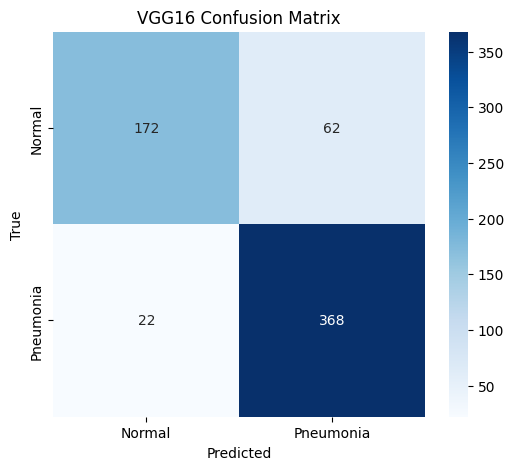

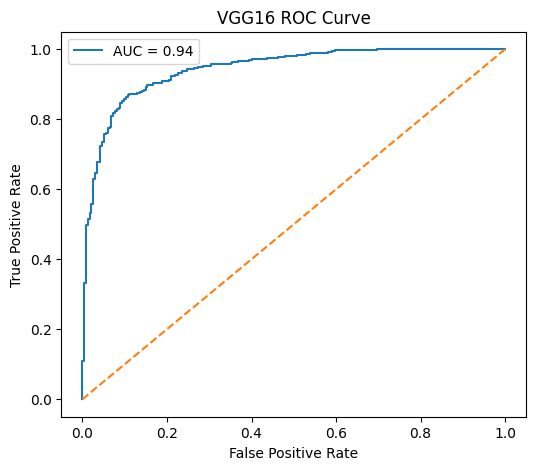

📁 All VGG16 results saved in results/VGG16/


In [ ]:
# ======================================
# VGG16: Training & Evaluation Pipeline
# ======================================
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import os

# -----------------------------
# 1. Define / Load VGG16
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
for param in vgg16.parameters():
    param.requires_grad = False  # freeze backbone

# Replace classifier
vgg16.classifier[6] = nn.Sequential(
    nn.Linear(4096, 1),
    nn.Sigmoid()
)
vgg16 = vgg16.to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(vgg16.classifier[6].parameters(), lr=0.001)

# -----------------------------
# 2. Training Loop
# -----------------------------
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=15, model_name="model"):
    history = {"train_loss": [], "val_loss": [], "val_acc": []}

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.float().to(device)

            optimizer.zero_grad()
            outputs = model(images).squeeze(1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)

        avg_train_loss = train_loss / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.float().to(device)
                outputs = model(images).squeeze(1)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)

                preds = (outputs > 0.5).float()
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        avg_val_loss = val_loss / len(val_loader.dataset)
        val_acc = correct / total

        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f} - Val Acc: {val_acc:.4f}")

    print(f"✅ {model_name} Training Completed!")
    return history

# Train VGG16
vgg16_history = train_model(vgg16, criterion, optimizer, train_loader, val_loader, num_epochs=15, model_name="VGG16")

# -----------------------------
# 3. Evaluation
# -----------------------------
y_true, y_pred, y_prob = [], [], []

vgg16.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images).squeeze(1)
        probs = outputs.cpu().numpy()
        preds = (outputs > 0.5).float().cpu().numpy()

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds)
        y_prob.extend(probs)

# Classification Report
report = classification_report(y_true, y_pred, target_names=["Normal", "Pneumonia"])
print("VGG16 Class-wise Metrics:\n", report)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal","Pneumonia"], yticklabels=["Normal","Pneumonia"])
plt.title("VGG16 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1],[0,1], linestyle="--")
plt.title("VGG16 ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# -----------------------------
# 4. Save Results
# -----------------------------
os.makedirs("results/VGG16", exist_ok=True)

with open("results/VGG16/classification_report.txt", "w") as f:
    f.write(report)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal","Pneumonia"], yticklabels=["Normal","Pneumonia"])
plt.title("VGG16 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig("results/VGG16/confusion_matrix.png")
plt.close()

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1],[0,1], linestyle="--")
plt.title("VGG16 ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.savefig("results/VGG16/roc_curve.png")
plt.close()

print("📁 All VGG16 results saved in results/VGG16/")


In [ ]:
# Save trained VGG16 model
torch.save(vgg16.state_dict(), "results/vgg16.pth")
print("✅ VGG16 model saved at results/vgg16.pth")


✅ VGG16 model saved at results/vgg16.pth


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to C:\Users\DELL/.cache\torch\hub\checkpoints\inception_v3_google-0cc3c7bd.pth


100%|██████████| 104M/104M [00:45<00:00, 2.38MB/s] 


Epoch 1/15 - Train Loss: 0.1599 - Val Loss: 0.2368 - Val Acc: 0.8750
Epoch 2/15 - Train Loss: 0.0752 - Val Loss: 0.2725 - Val Acc: 0.8750
Epoch 3/15 - Train Loss: 0.0662 - Val Loss: 0.2734 - Val Acc: 0.8750
Epoch 4/15 - Train Loss: 0.0475 - Val Loss: 0.2080 - Val Acc: 0.8750
Epoch 5/15 - Train Loss: 0.0460 - Val Loss: 0.2322 - Val Acc: 0.8125
Epoch 6/15 - Train Loss: 0.0365 - Val Loss: 0.7918 - Val Acc: 0.6250
Epoch 7/15 - Train Loss: 0.0429 - Val Loss: 0.1452 - Val Acc: 1.0000
Epoch 8/15 - Train Loss: 0.0310 - Val Loss: 0.9424 - Val Acc: 0.6250
Epoch 9/15 - Train Loss: 0.0300 - Val Loss: 0.9475 - Val Acc: 0.6250
Epoch 10/15 - Train Loss: 0.0248 - Val Loss: 0.7774 - Val Acc: 0.8125
Epoch 11/15 - Train Loss: 0.0307 - Val Loss: 0.1695 - Val Acc: 0.8750
Epoch 12/15 - Train Loss: 0.0200 - Val Loss: 0.1665 - Val Acc: 0.9375
Epoch 13/15 - Train Loss: 0.0207 - Val Loss: 0.9066 - Val Acc: 0.6250
Epoch 14/15 - Train Loss: 0.0199 - Val Loss: 0.2294 - Val Acc: 0.8750
Epoch 15/15 - Train Loss: 0.0

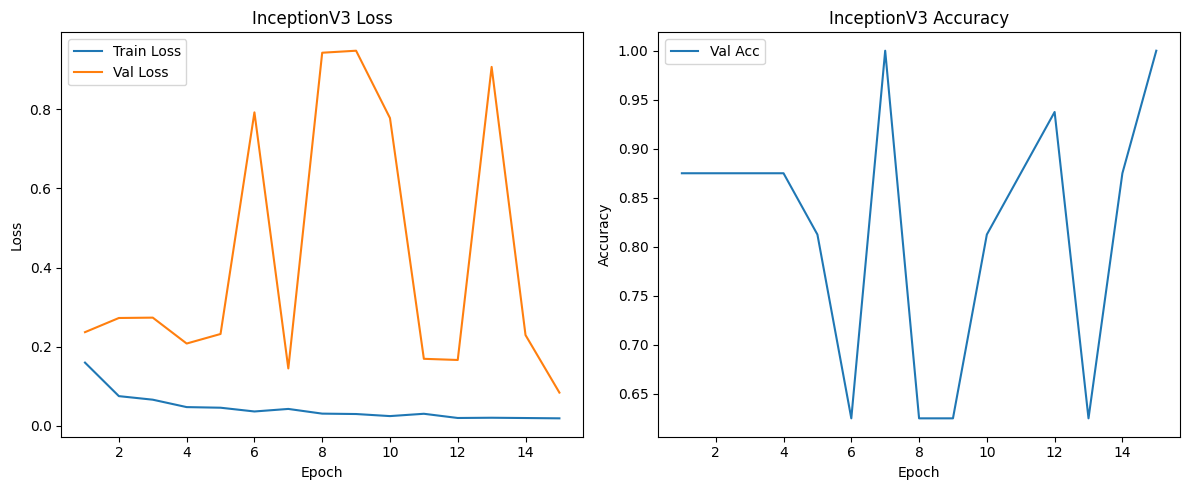

Class-wise Metrics:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00         8
   Pneumonia       1.00      1.00      1.00         8

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16



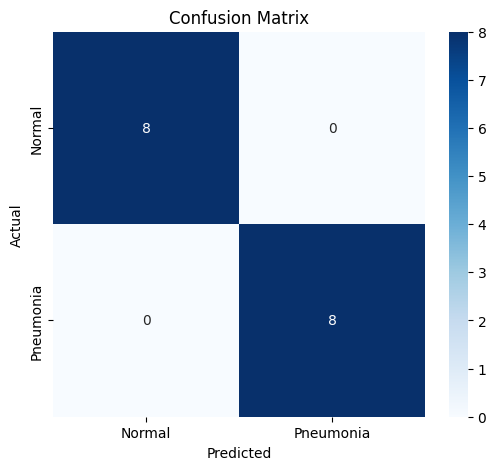

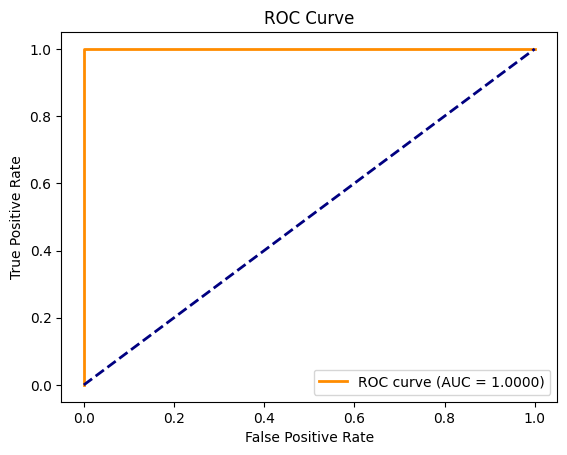

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# Ensure results folder exists
os.makedirs("results", exist_ok=True)

# --------------------------
# 1. Model setup
# --------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained InceptionV3 with aux_logits=True (required by torchvision)
inception = models.inception_v3(weights="IMAGENET1K_V1", aux_logits=True)

# Disable the auxiliary classifier (not needed for our task)
inception.aux_logits = False
if inception.AuxLogits is not None:
    inception.AuxLogits = None

# Replace the final fully connected layer
num_features = inception.fc.in_features
inception.fc = nn.Sequential(
    nn.Linear(num_features, 1),
    nn.Sigmoid()
)

inception = inception.to(device)


# --------------------------
# 2. Loss & optimizer
# --------------------------
criterion = nn.BCELoss()
optimizer = optim.Adam(inception.parameters(), lr=1e-4, weight_decay=1e-5)

# --------------------------
# 3. Training function
# --------------------------
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=15, model_name="model"):
    history = {"train_loss": [], "val_loss": [], "val_acc": []}

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        history["train_loss"].append(epoch_loss)

        # Validation
        model.eval()
        correct = 0
        total = 0
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                predicted = (outputs > 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_acc = correct / total
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_loss:.4f} - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.4f}")

    # Save the model
    torch.save(model.state_dict(), f"results/{model_name}.pth")
    print(f"✅ Training completed. Model saved as results/{model_name}.pth")
    return history

# --------------------------
# 4. Evaluation function
# --------------------------
def evaluate_model(model, loader):
    model.eval()
    y_true, y_pred, y_prob = [], [], []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(images)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend((outputs > 0.5).float().cpu().numpy())
            y_prob.extend(outputs.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_prob = np.array(y_prob)

    # Metrics
    print("Class-wise Metrics:")
    print(classification_report(y_true, y_pred, target_names=["Normal", "Pneumonia"]))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Pneumonia"], yticklabels=["Normal", "Pneumonia"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.savefig("results/inceptionv3_confusion_matrix.png")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.savefig("results/inceptionv3_roc_curve.png")
    plt.show()

# --------------------------
# 5. Plot history
# --------------------------
def plot_history(history, model_name="model"):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(12, 5))
    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.title(f"{model_name} Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["val_acc"], label="Val Acc")
    plt.title(f"{model_name} Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"results/{model_name}_history.png")
    plt.show()

# --------------------------
# 6. Run training & evaluation
# --------------------------
# Make sure you have `train_loader` and `val_loader` already defined
inception_history = train_model(inception, criterion, optimizer, train_loader, val_loader, num_epochs=15, model_name="inceptionv3")
plot_history(inception_history, model_name="InceptionV3")
evaluate_model(inception, val_loader)


Using device: cpu


c:\Users\DELL\Desktop\AI_ML Research Projects\chest_xray_pneumonia\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\DELL\Desktop\AI_ML Research Projects\chest_xray_pneumonia\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/15 - Train Loss: 0.1056 - Val Loss: 0.0644 - Val Acc: 1.0000
Epoch 2/15 - Train Loss: 0.0448 - Val Loss: 0.1309 - Val Acc: 1.0000
Epoch 3/15 - Train Loss: 0.0289 - Val Loss: 0.0052 - Val Acc: 1.0000
Epoch 4/15 - Train Loss: 0.0292 - Val Loss: 0.0055 - Val Acc: 1.0000
Epoch 5/15 - Train Loss: 0.0321 - Val Loss: 0.0419 - Val Acc: 1.0000
Epoch 6/15 - Train Loss: 0.0157 - Val Loss: 0.1146 - Val Acc: 0.9375
Epoch 7/15 - Train Loss: 0.0154 - Val Loss: 0.0525 - Val Acc: 1.0000
Epoch 8/15 - Train Loss: 0.0074 - Val Loss: 0.0478 - Val Acc: 0.9375
Epoch 9/15 - Train Loss: 0.0120 - Val Loss: 0.0673 - Val Acc: 0.9375
Epoch 10/15 - Train Loss: 0.0140 - Val Loss: 0.3948 - Val Acc: 0.9375
Epoch 11/15 - Train Loss: 0.0150 - Val Loss: 0.0461 - Val Acc: 1.0000
Epoch 12/15 - Train Loss: 0.0126 - Val Loss: 0.2317 - Val Acc: 0.8750
Epoch 13/15 - Train Loss: 0.0060 - Val Loss: 0.0362 - Val Acc: 1.0000
Epoch 14/15 - Train Loss: 0.0045 - Val Loss: 0.1983 - Val Acc: 0.9375
Epoch 15/15 - Train Loss: 0.0

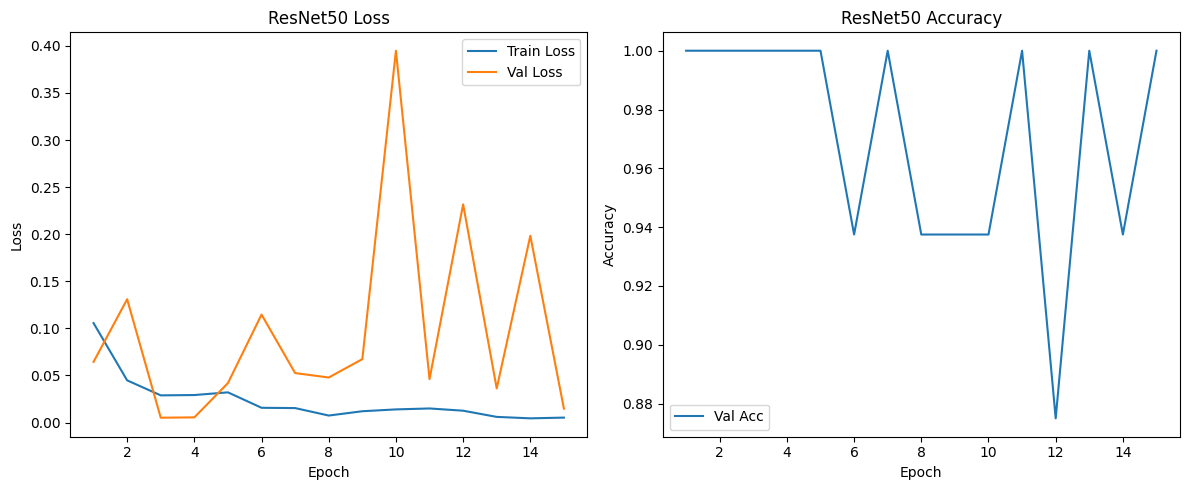

Class-wise Metrics:
              precision    recall  f1-score   support

      NORMAL       0.97      0.31      0.47       234
   PNEUMONIA       0.71      0.99      0.83       390

    accuracy                           0.74       624
   macro avg       0.84      0.65      0.65       624
weighted avg       0.81      0.74      0.69       624



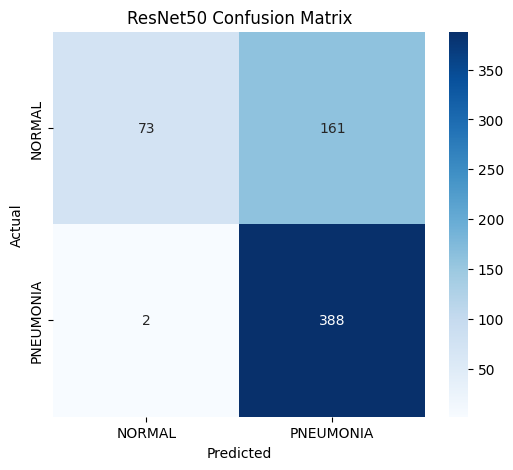

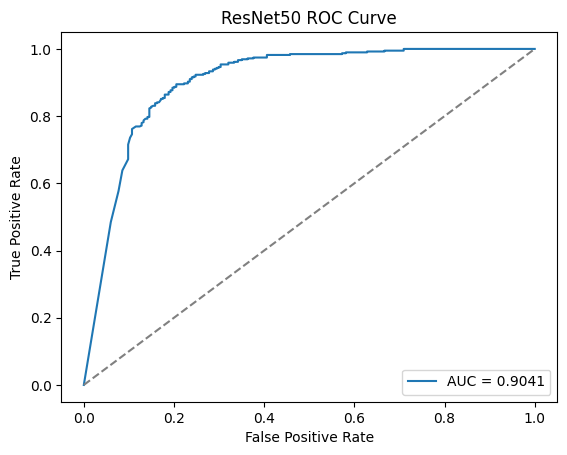

In [41]:
# -----------------------------
# 1. Imports
# -----------------------------
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns

# -----------------------------
# 2. Paths to dataset
# -----------------------------
train_dir = r"C:\Users\DELL\Desktop\AI_ML Research Projects\chest_xray_pneumonia\data\raw\train"
val_dir   = r"C:\Users\DELL\Desktop\AI_ML Research Projects\chest_xray_pneumonia\data\raw\val"
test_dir  = r"C:\Users\DELL\Desktop\AI_ML Research Projects\chest_xray_pneumonia\data\raw\test"

# -----------------------------
# 3. Image Transformations
# -----------------------------
img_size = 224

train_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# -----------------------------
# 4. Datasets & Loaders
# -----------------------------
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset   = datasets.ImageFolder(val_dir, transform=val_test_transforms)
test_dataset  = datasets.ImageFolder(test_dir, transform=val_test_transforms)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False)

# -----------------------------
# 5. Device
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -----------------------------
# 6. Model Setup (ResNet50 example)
# -----------------------------
resnet50 = models.resnet50(pretrained=True)
num_features = resnet50.fc.in_features
resnet50.fc = nn.Sequential(
    nn.Linear(num_features, 1),
    nn.Sigmoid()
)
resnet50 = resnet50.to(device)

# -----------------------------
# 7. Loss and Optimizer
# -----------------------------
criterion = nn.BCELoss()
optimizer = optim.Adam(resnet50.parameters(), lr=1e-4)

# -----------------------------
# 8. Training function
# -----------------------------
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=15, model_name="model"):
    history = {"train_loss": [], "val_loss": [], "val_acc": []}
    
    for epoch in range(num_epochs):
        # Train
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        epoch_train_loss = running_loss / len(train_loader.dataset)
        
        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                preds = (outputs > 0.5).float()
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_acc = correct / total
        
        history["train_loss"].append(epoch_train_loss)
        history["val_loss"].append(epoch_val_loss)
        history["val_acc"].append(epoch_val_acc)
        
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f} - Val Loss: {epoch_val_loss:.4f} - Val Acc: {epoch_val_acc:.4f}")
    
    # Save model
    os.makedirs("results", exist_ok=True)
    torch.save(model.state_dict(), f"results/{model_name}.pth")
    print(f"✅ Training completed. Model saved as results/{model_name}.pth")
    return history

# -----------------------------
# 9. Plotting function
# -----------------------------
def plot_history(history, model_name="model"):
    epochs = range(1, len(history["train_loss"]) + 1)
    
    plt.figure(figsize=(12,5))
    
    # Loss
    plt.subplot(1,2,1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.title(f"{model_name} Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    
    # Accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, history["val_acc"], label="Val Acc")
    plt.title(f"{model_name} Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f"results/{model_name}_history.png")
    plt.show()

# -----------------------------
# 10. Train the model
# -----------------------------
resnet50_history = train_model(resnet50, criterion, optimizer, train_loader, val_loader, num_epochs=15, model_name="ResNet50")
plot_history(resnet50_history, "ResNet50")

# -----------------------------
# 11. Evaluation on test set
# -----------------------------
resnet50.eval()
y_true, y_pred, y_prob = [], [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
        outputs = resnet50(images)
        y_prob.extend(outputs.cpu().numpy().flatten())
        preds = (outputs > 0.5).float()
        y_pred.extend(preds.cpu().numpy().flatten())
        y_true.extend(labels.cpu().numpy().flatten())

# Class-wise metrics
print("Class-wise Metrics:")
print(classification_report(y_true, y_pred, target_names=test_dataset.classes))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("ResNet50 Confusion Matrix")
plt.savefig("results/ResNet50_confusion_matrix.png")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ResNet50 ROC Curve")
plt.legend(loc="lower right")
plt.savefig("results/ResNet50_ROC.png")
plt.show()


## 🔍 Model Explainability with Grad-CAM (ResNet50)


In [9]:
model = models.resnet50(weights=None)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 1)   # keep Sequential for compatibility
)

# now load works
model.load_state_dict(torch.load("results/ResNet50.pth", map_location=device))
model = model.to(device)
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [13]:
import torch
import torch.nn as nn
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load ResNet50 backbone
model = models.resnet50(weights=None)  # no pretrained weights
num_ftrs = model.fc.in_features

# ⚡ Match EXACT training architecture
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 1)   # binary classification (NORMAL / PNEUMONIA)
)

# Load checkpoint
state_dict = torch.load("results/ResNet50.pth", map_location=device)
model.load_state_dict(state_dict)

# Move to device & eval
model = model.to(device)
model.eval()

print("✅ Model loaded successfully!")


✅ Model loaded successfully!


Chosen image: C:/Users/DELL/Desktop/AI_ML Research Projects/chest_xray_pneumonia/data/raw/test\NORMAL\NORMAL2-IM-0350-0001.jpeg


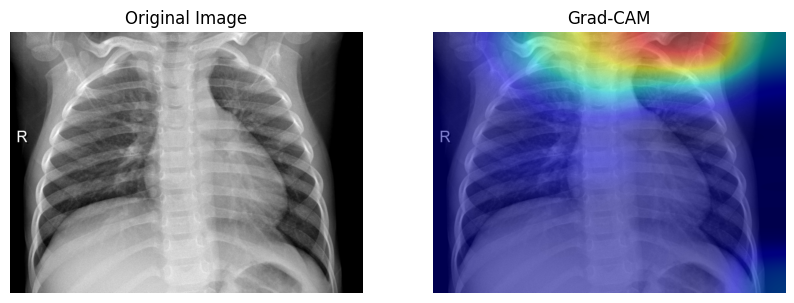

In [22]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import random

# ------------------------
# 1. Device Setup
# ------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------------
# 2. Load Model
# ------------------------
model = models.resnet50(weights=None)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(nn.Linear(num_ftrs, 1))  # Binary classification
model.load_state_dict(torch.load("results/ResNet50.pth", map_location=device))
model = model.to(device)
model.eval()

# ------------------------
# 3. Transform for Input
# ------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ------------------------
# 4. Grad-CAM Implementation
# ------------------------
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook()

    def hook(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor, class_idx=None):
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = torch.argmax(output)

        self.model.zero_grad()
        output[:, class_idx].backward()

        weights = self.gradients.mean(dim=[2, 3], keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = torch.relu(cam)
        cam = cam.squeeze().cpu().numpy()
        cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam) + 1e-8)
        return cam

# Attach GradCAM to the last conv layer of ResNet50
grad_cam = GradCAM(model, model.layer4[-1])

# ------------------------
# 5. Image Loader
# ------------------------
def load_image(path):
    img = Image.open(path).convert("RGB")
    tensor = transform(img).unsqueeze(0).to(device)
    return img, tensor

# ------------------------
# 6. Pick a Random Test Image
# ------------------------
test_dir = r"C:/Users/DELL/Desktop/AI_ML Research Projects/chest_xray_pneumonia/data/raw/test"
class_names = ["NORMAL", "PNEUMONIA"]

chosen_class = random.choice(class_names)
chosen_image = random.choice(os.listdir(os.path.join(test_dir, chosen_class)))
img_path = os.path.join(test_dir, chosen_class, chosen_image)

print(f"Chosen image: {img_path}")

orig_img, input_tensor = load_image(img_path)

# ------------------------
# 7. Generate Grad-CAM Heatmap
# ------------------------
cam = grad_cam.generate(input_tensor, class_idx=0)  # 0 = NORMAL, 1 = PNEUMONIA

# Resize CAM to match image size
cam_resized = np.array(Image.fromarray(cam).resize(orig_img.size, resample=Image.BICUBIC))

# Overlay CAM on image
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(orig_img)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Grad-CAM")
plt.imshow(orig_img)
plt.imshow(cam_resized, cmap='jet', alpha=0.5)  # Overlay heatmap
plt.axis("off")

plt.show()


Chosen image: C:/Users/DELL/Desktop/AI_ML Research Projects/chest_xray_pneumonia/data/raw/test\NORMAL\IM-0030-0001.jpeg
Predicted: PNEUMONIA (Confidence: 1.00)


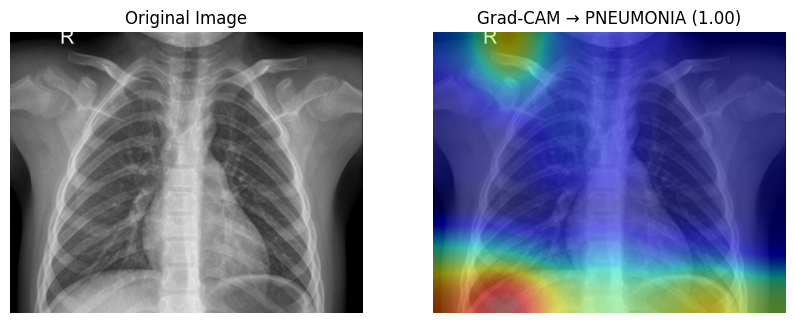

In [27]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import random

# ------------------------
# 1. Device Setup
# ------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------------
# 2. Load Model
# ------------------------
model = models.resnet50(weights=None)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(nn.Linear(num_ftrs, 1))  # Binary classification
model.load_state_dict(torch.load("results/ResNet50.pth", map_location=device))
model = model.to(device)
model.eval()

# ------------------------
# 3. Transform for Input
# ------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ------------------------
# 4. Grad-CAM Implementation
# ------------------------
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook()

    def hook(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor, class_idx=None):
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = torch.argmax(output)

        self.model.zero_grad()
        output[:, 0].backward()  # since it's binary classification

        weights = self.gradients.mean(dim=[2, 3], keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = torch.relu(cam)
        cam = cam.squeeze().cpu().numpy()
        cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam) + 1e-8)
        return cam, output

# Attach GradCAM to the last conv layer of ResNet50
grad_cam = GradCAM(model, model.layer4[-1])

# ------------------------
# 5. Image Loader
# ------------------------
def load_image(path):
    img = Image.open(path).convert("RGB")
    tensor = transform(img).unsqueeze(0).to(device)
    return img, tensor

# ------------------------
# 6. Pick a Random Test Image
# ------------------------
test_dir = r"C:/Users/DELL/Desktop/AI_ML Research Projects/chest_xray_pneumonia/data/raw/test"
class_names = ["NORMAL", "PNEUMONIA"]

chosen_class = random.choice(class_names)
chosen_image = random.choice(os.listdir(os.path.join(test_dir, chosen_class)))
img_path = os.path.join(test_dir, chosen_class, chosen_image)

print(f"Chosen image: {img_path}")

orig_img, input_tensor = load_image(img_path)

# ------------------------
# 7. Generate Grad-CAM Heatmap & Prediction
# ------------------------
cam, output = grad_cam.generate(input_tensor, class_idx=0)

# Prediction (sigmoid since binary)
prob = torch.sigmoid(output).item()
pred_class = "PNEUMONIA" if prob > 0.5 else "NORMAL"
confidence = prob if prob > 0.5 else 1 - prob

print(f"Predicted: {pred_class} (Confidence: {confidence:.2f})")

# Resize CAM to match image size
cam_resized = np.array(Image.fromarray(cam).resize(orig_img.size, resample=Image.BICUBIC))

# ------------------------
# 8. Show Original + Grad-CAM
# ------------------------
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(orig_img)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title(f"Grad-CAM → {pred_class} ({confidence:.2f})")
plt.imshow(orig_img)
plt.imshow(cam_resized, cmap='jet', alpha=0.5)  # Overlay heatmap
plt.axis("off")

plt.show()


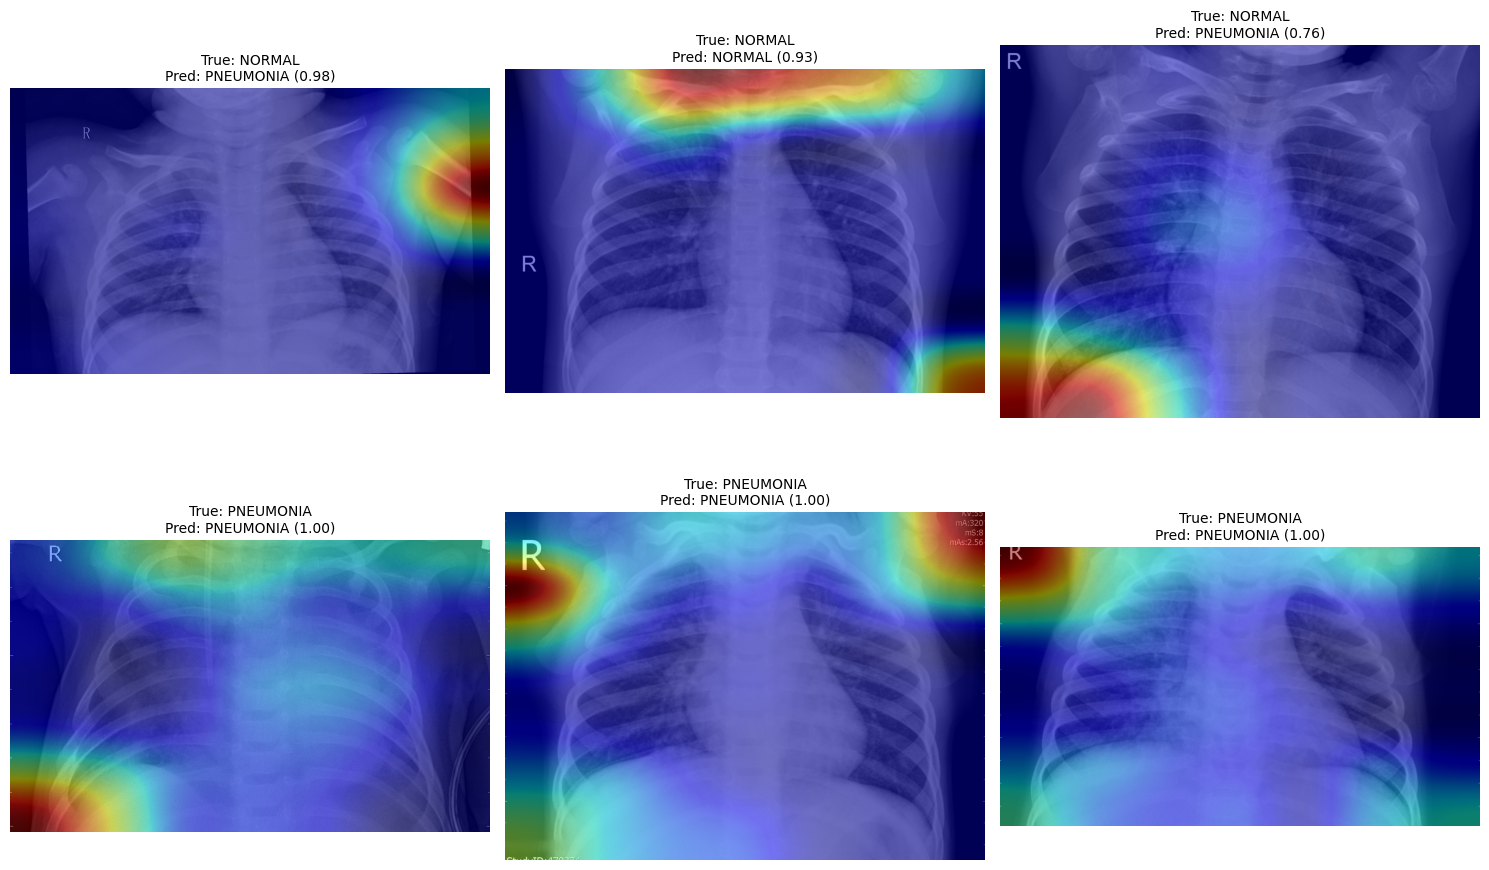

In [28]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import random

# ------------------------
# 1. Device Setup
# ------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------------
# 2. Load Model
# ------------------------
model = models.resnet50(weights=None)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(nn.Linear(num_ftrs, 1))  # Binary classification
model.load_state_dict(torch.load("results/ResNet50.pth", map_location=device))
model = model.to(device)
model.eval()

# ------------------------
# 3. Transform for Input
# ------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ------------------------
# 4. Grad-CAM Implementation
# ------------------------
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook()

    def hook(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor):
        output = self.model(input_tensor)

        self.model.zero_grad()
        output[:, 0].backward()

        weights = self.gradients.mean(dim=[2, 3], keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = torch.relu(cam)
        cam = cam.squeeze().cpu().numpy()
        cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam) + 1e-8)
        return cam, output

# Attach GradCAM to the last conv layer of ResNet50
grad_cam = GradCAM(model, model.layer4[-1])

# ------------------------
# 5. Image Loader
# ------------------------
def load_image(path):
    img = Image.open(path).convert("RGB")
    tensor = transform(img).unsqueeze(0).to(device)
    return img, tensor

# ------------------------
# 6. Batch Testing
# ------------------------
test_dir = r"C:/Users/DELL/Desktop/AI_ML Research Projects/chest_xray_pneumonia/data/raw/test"
class_names = ["NORMAL", "PNEUMONIA"]

N = 6  # number of random images to test
all_images = []
for cls in class_names:
    cls_path = os.path.join(test_dir, cls)
    files = random.sample(os.listdir(cls_path), N // 2)  # half from each class
    for f in files:
        all_images.append((os.path.join(cls_path, f), cls))

# ------------------------
# 7. Run Grad-CAM for Each Image
# ------------------------
plt.figure(figsize=(15, 10))
for idx, (img_path, true_cls) in enumerate(all_images):
    orig_img, input_tensor = load_image(img_path)
    cam, output = grad_cam.generate(input_tensor)

    prob = torch.sigmoid(output).item()
    pred_class = "PNEUMONIA" if prob > 0.5 else "NORMAL"
    confidence = prob if prob > 0.5 else 1 - prob

    cam_resized = np.array(Image.fromarray(cam).resize(orig_img.size, resample=Image.BICUBIC))

    plt.subplot(2, N // 2, idx + 1)
    plt.imshow(orig_img)
    plt.imshow(cam_resized, cmap='jet', alpha=0.5)
    plt.axis("off")
    plt.title(f"True: {true_cls}\nPred: {pred_class} ({confidence:.2f})", fontsize=10)

plt.tight_layout()
plt.show()
